<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-kamilla-jaroslav/blob/main/cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%%capture
!pip install torch torchvision matplotlib pytorch_ssim





In [ ]:
import zipfile

# Укажите имя файла с расширением .zip
zip_file = "processed_images.zip"  # Замените на имя вашего файла

# Укажите папку для распаковки
output_folder = "/processed_images"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print(f"Данные распакованы в папку: {output_folder}")

Данные распакованы в папку: /processed_images


In [ ]:
import os

# Проверка содержимого распакованной папки
os.listdir(output_folder)

['processed_experiment_images', 'processed_simulation_images']

Epoch [1/100], Generator Loss: 3.0849318504333496, Discriminator Loss: 0.0715659037232399


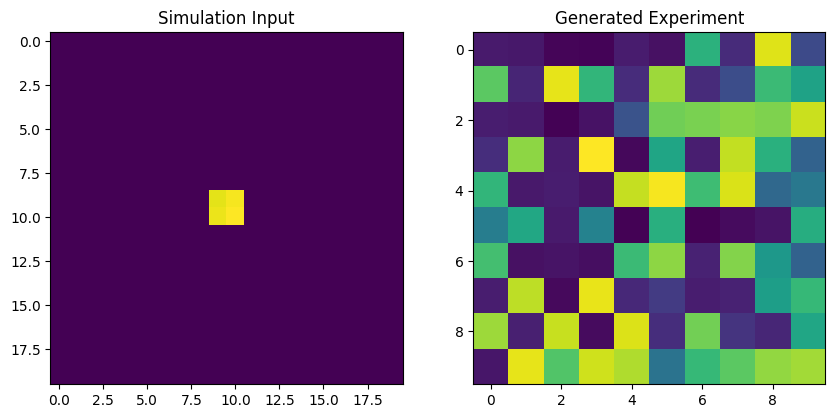

Epoch [2/100], Generator Loss: 2.5449986457824707, Discriminator Loss: 0.00016295473324134946
Epoch [3/100], Generator Loss: 3.792313814163208, Discriminator Loss: 0.044245414435863495
Epoch [4/100], Generator Loss: 2.241773843765259, Discriminator Loss: 0.002099229721352458
Epoch [5/100], Generator Loss: 2.0326967239379883, Discriminator Loss: 0.003570806235074997
Epoch [6/100], Generator Loss: 2.5060229301452637, Discriminator Loss: 0.009584302082657814
Epoch [7/100], Generator Loss: 2.307680606842041, Discriminator Loss: 0.0003551566624082625
Epoch [8/100], Generator Loss: 2.320178270339966, Discriminator Loss: 0.0002948783803731203
Epoch [9/100], Generator Loss: 2.2940287590026855, Discriminator Loss: 0.0002873898483812809
Epoch [10/100], Generator Loss: 2.245751142501831, Discriminator Loss: 0.0020382737275213003
Epoch [11/100], Generator Loss: 2.3689513206481934, Discriminator Loss: 0.0016763054300099611


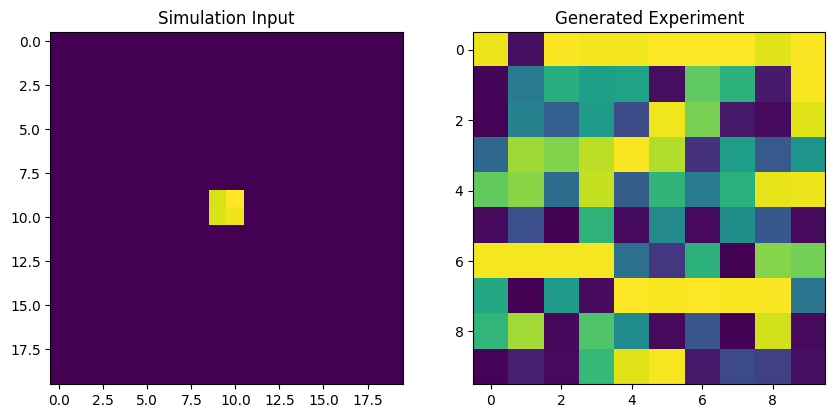

KeyboardInterrupt: 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
from tqdm import tqdm
from pytorch_ssim import SSIM

# Утилита для загрузки данных
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        image = (image - 0.5) * 2
        image = np.expand_dims(image, axis=0).astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image)

# Параметры загрузки данных
simulation_dir = "/processed_images/processed_simulation_images"
experiment_dir = "/processed_images/processed_experiment_images"

# Загрузка данных
sim_dataset = ImageDataset(simulation_dir)
exp_dataset = ImageDataset(experiment_dir)

sim_dataloader = DataLoader(sim_dataset, batch_size=16, shuffle=True)
exp_dataloader = DataLoader(exp_dataset, batch_size=16, shuffle=True)

# Модель генератора с U-Net архитектурой
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Модель дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1)  # padding целое число
        )

    def forward(self, x):
        return self.model(x)



# Инициализация моделей
gen = Generator().cuda()  # Инициализация генератора
disc = Discriminator().cuda()  # Инициализация дискриминатора

def cycle_loss(real, reconstructed):
    # Приводим размеры изображений к одинаковым
    if real.size() != reconstructed.size():
        reconstructed = F.interpolate(reconstructed, size=real.size()[2:], mode='bilinear', align_corners=False)

    return torch.mean(torch.abs(real - reconstructed))

# Оптимизаторы
gen_optimizer = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Обучение
epochs = 100
for epoch in range(epochs):
    for sim_images, exp_images in zip(sim_dataloader, exp_dataloader):
        sim_images, exp_images = sim_images.cuda(), exp_images.cuda()

        # Генерация
        fake_exp = gen(sim_images)
        fake_sim = gen(exp_images)

        # Обучение дискриминаторов
        disc_optimizer.zero_grad()
        real_loss_exp = torch.mean((disc(exp_images) - 1) ** 2)
        fake_loss_exp = torch.mean(disc(fake_exp) ** 2)
        disc_loss_exp = (real_loss_exp + fake_loss_exp) / 2

        real_loss_sim = torch.mean((disc(sim_images) - 1) ** 2)
        fake_loss_sim = torch.mean(disc(fake_sim) ** 2)
        disc_loss_sim = (real_loss_sim + fake_loss_sim) / 2

        disc_loss = (disc_loss_exp + disc_loss_sim) / 2
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # Обучение генераторов
        gen_optimizer.zero_grad()
        gen_loss_exp = torch.mean((disc(fake_exp) - 1) ** 2)
        gen_loss_sim = torch.mean((disc(fake_sim) - 1) ** 2)

        cycle_loss_exp = cycle_loss(exp_images, gen(fake_sim))
        cycle_loss_sim = cycle_loss(sim_images, gen(fake_exp))

        gen_loss = gen_loss_exp + gen_loss_sim + 10 * (cycle_loss_exp + cycle_loss_sim)
        gen_loss.backward()
        gen_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {gen_loss.item()}, Discriminator Loss: {disc_loss.item()}")

    # Визуализация результатов каждые 10 эпох
    if epoch % 10 == 0:
        with torch.no_grad():
            example_sim = sim_images[0:1]
            example_generated = gen(example_sim)[0]
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Simulation Input")
            plt.imshow(example_sim[0].cpu().numpy().squeeze(), cmap="viridis")
            plt.subplot(1, 2, 2)
            plt.title("Generated Experiment")
            plt.imshow(example_generated.cpu().numpy().squeeze(), cmap="viridis")
            plt.show()